In [19]:
## Define code:
from bb_ions import *

# [[30, 4, 5]] From Ye Delfosse long chain [2503.22071]:
l = 5
m = 3
# A = x^0 + x
# B = x^0 + y + x^2*y^2   (from Table II)

x, y, z = make_xyz(l,m)
x0 = np.linalg.matrix_power(x,0)

A1 = x0
A2 = np.zeros((l*m, l*m), dtype = int)
A3 = x
B1 = x0
B2 = y
B3 = z @ z

A = A1 + A2 + A3
B = B1 + B2 + B3

Hx = np.hstack((A, B))
Hz = np.hstack((B.T, A.T))

## Find logical operators:
Lx, Lz = autqec_logical_ops(Hx, Hz)

In [20]:
# Find d:

import json
from bposd import css_decode_sim

osd_options={
'target_runs': 2000,
'xyz_error_bias': [1, 1, 1],
'bp_method': "minimum_sum",
'ms_scaling_factor': 0.05,
'osd_method': "osd_cs",
'osd_order': 4,
'channel_update': None,
'seed': 42,
'max_iter': 9,
# 'output_file': "test.json",
'error_bar_precision_cutoff': 1e-6
}

error_rate = 0.1
bb5 = css_decode_sim.css_decode_sim(hx = Hx, hz = Hz, error_rate = error_rate, **osd_options) #bposd decoder (to find the dist)

results = json.loads(bb5.output_dict())
d_max = results["min_logical_weight"]

RNG Seed: 42
Constructing CSS code from hx and hz matrices...
Checking the CSS code is valid...
<Unnamed CSS code>
 -Block dimensions: Pass
 -PCMs commute hz@hx.T==0: Pass
 -PCMs commute hx@hz.T==0: Pass
 -lx \in ker{hz} AND lz \in ker{hx}: Pass
 -lx and lz anticommute: Pass
 -<Unnamed CSS code> is a valid CSS code w/ params [30,4,nan]


d_max: 5; OSDW_WER: 7.9±0.25%; OSDW: 28±1%; OSD0: 29.8±1%;: 100% 2000/2000 [00:00<00:00, 2206.76it/s]       


In [21]:
# Read off A and B above
from bb_ions import *
# A = x^0 + x
# B = x^0 + y + x^2*y^2  

# Writing tuples (i, j) for each term x^i⋅y^j :
A = [(0, 0), (1, 0)]
B = [(0, 0), (0, 1), (2, 2)]

IA, JA = findIJ(A)
IB, JB = findIJ(B)

Junion = sorted(set(JA + JB))

In [22]:
import stim


# Code parameters
d = d_max

## Circuit paramaters:
p = 0
t_init = 0
t_had = 0
p_init = 0


## Construct circuit:

qC, qL, qR, _ = new_make_registers(l, m) # compulsory order for registers given the hardcoding in CNOTs / CZs below

c = stim.Circuit()

for round in range(d):
    
    # Initialise:

    initZ(c, qC, p) # initialise check qubits to |0⟩
    if round != 0:
        idleZ(c, qL + qR, p_idle(t_init))
    tick(c)

    hadamard(c, qC, p) # hadamard check qubits to |+⟩
    if round == 0: # If zeroth round initialise the data qubits:
        initZ(c, qL + qR, p_init)
    else: # if subsequent rounds idle the data qubits during hadamard:
        idleZ(c, qL + qR, p_idle(t_had)) 
    tick(c)

    # X-check CNOTs:

    prev_j = 0 # start with each M^a_w aligned with M^d_w

    for jval in Junion:

        if jval != prev_j: # i.e. modules are not aligned with required j value -- this will always be the case apart from if the very first jval is zero.
            
            # Cyclic shift check qubits:
            t_shift = abs(jval - prev_j)
            apply_shift_error(c, qC, p_shift(t_shift)) 
            
            # Idle data qubits:
            idleZ(c, qL + qR, p_idle(t_shift))
            
            tick(c)

        # # Merge Coulomb potentials:
        #### --- UP TO HERE

        # for (i, j) in A:
        #     if j == jval:  # i.e. this (i, j) appears in A
                

        # # for i such that x^i⋅y^j appears in B: 
        # for (i, j) in B:
        #     if j == jval:
        #         # do CNOTs
        
        # prev_j = jval





    # Measure check qubits
    # Add detectors (only on )
    # Z-check CZs
    # Measure check qubits
    # Add detectors 

In [23]:
from bb_ions import *
l = 5
m = 3


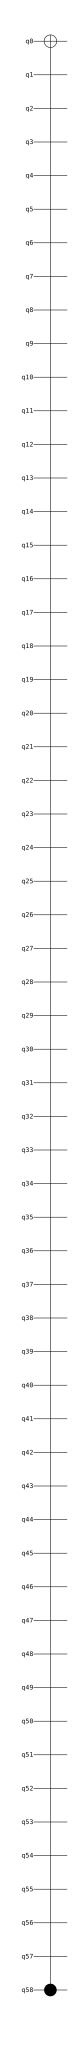

In [24]:
import stim
from bb_ions import *

l = 5
m = 3


c = stim.Circuit()

'''let 
    u = 0 be left data qubits
    u = 1 be right data qubits
    u = 2 be check qubits
'''
c.append("CNOT", [convtok(l, m, 3, 4, 1), convtok(l, m, 0, 0, 0)])

c.diagram("timeline-svg")

